# Granite Plan-Solve Agent

This notebook demonstrates a **Plan-Solve Agent** that can break down complex tasks into executable steps, execute them using the function calling agent, and adapt the plan based on results.

A [Plan-Solve Agent](https://arxiv.org/abs/2305.04091) pattern follows these steps:

1. **Planning Phase**: The agent analyzes a user request and creates a step-by-step plan
2. **Execution Phase**: The agent executes each step using function calling with available tools
3. **Replanning Phase**: The agent reviews progress and updates the plan based on results
4. **Iteration**: The cycle continues until the task is complete

This approach allows the agent to handle multi-step tasks by :

- Breaking down complex requests into manageable steps
- Using external tools to gather information
- Adapting the plan based on intermediate results
- Coordinating multiple tool calls to achieve the final goal

This pattern allows a more structured task breakdown with stronger error recovery by separatig planning phase from acting and avoids premature incomplete answers.

This notebooks leverages ibm [granite-4.0.h-small](https://huggingface.co/ibm-granite/granite-4.0-h-small) which features improved instruction following (IF) and tool-calling capabilities and is a suitable model for a Plan-Solve pattern.

**Execution Flow:**
1. `planner_node` analyzes the user request and creates an initial structured plan
2. `function_calling_agent` executes the plan steps, invoking tools as needed based on `Function Calling` [recipe](https://github.com/ibm-granite-community/granite-agent-cookbook/blob/main/recipes/Function_Calling/Function_Calling_Agent.ipynb)
3. Results return to `replan` which reviews progress and updates the plan
4. The cycle continues (replan → function_calling_agent) until all steps are complete or `plan_complete` is called

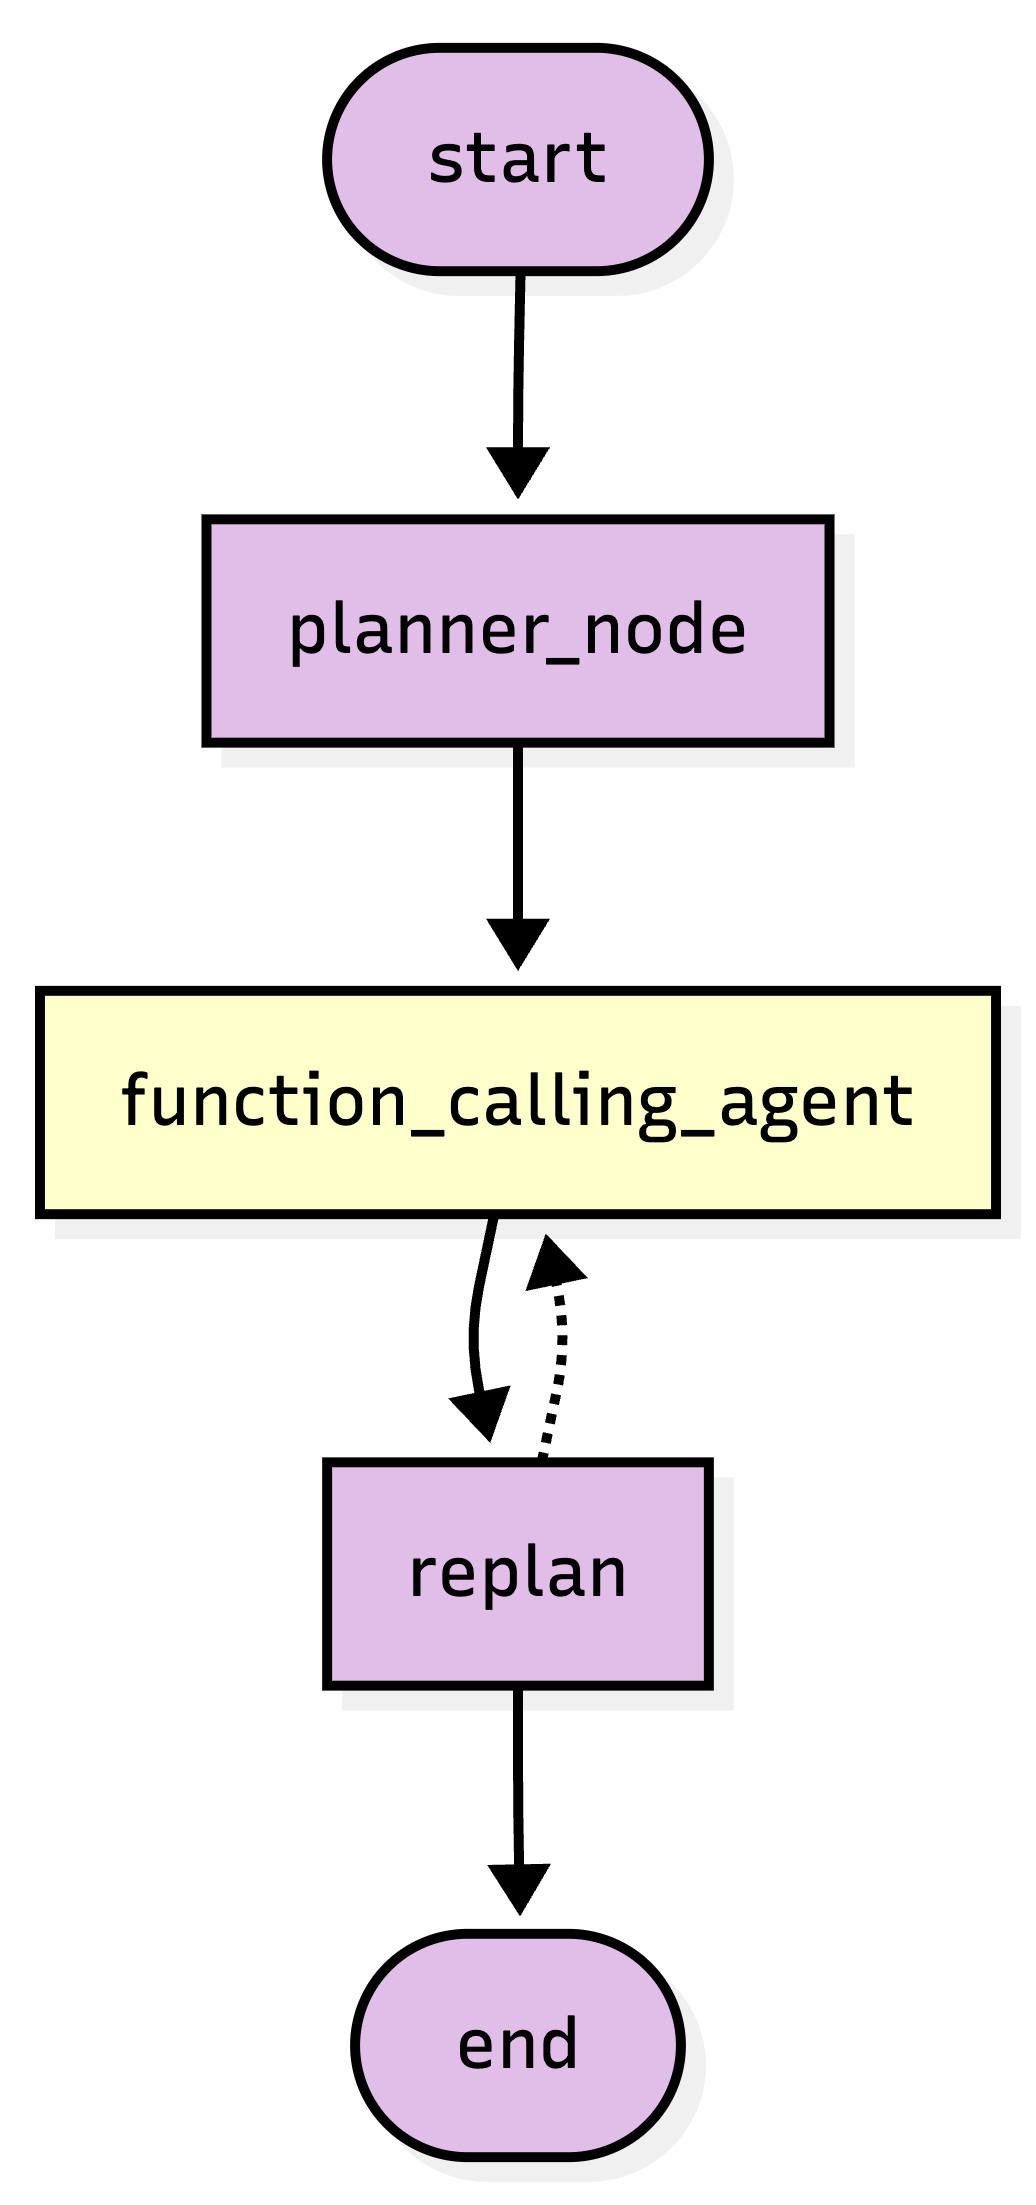

## Plan-Solve Agent Implementation Steps

This notebook will guide you through building a comprehensive Plan-Solve Agent with the following steps:

1. **Environment Setup**: Configure watsonx.ai credentials and install dependencies

2. **Build Plan-Solve Agent Graph**: Construct the complete agent architecture


3. **Execute the Plan-Solve Agent**: Run examples and demonstrate capabilities

4. **Conclusion**: Summary of capabilities

## 1. Environment Setup

This Plan-Solve Agent requires several components to function properly

## Prerequisites
- **Python 3.11+**: The notebook is compatible with Python 3.11 and 3.12
- **Jupyter Notebook**: Best suited for interactive development and visualization
- **watsonx.ai Access**: You'll need credentials for IBM's watsonx.ai platform
- **API Keys**: Optional API keys for weather and stock market data (with fallback demo data)

In [ ]:
! echo "::group::Install Dependencies"
%pip install uv
! uv pip install "git+https://github.com/ibm-granite-community/utils.git" \
    langgraph \
    langchain \
    langchain_ibm \
    matplotlib
! echo "::endgroup::"

In [ ]:
import operator
import re
from datetime import datetime
from typing import Annotated, TypedDict
from IPython.display import Image, display
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from ibm_granite_community.notebook_utils import get_env_var
from langchain.chat_models import init_chat_model
from langchain_core.messages import AnyMessage, AIMessage, HumanMessage, SystemMessage, ToolCall, ToolMessage
from langchain_core.tools import BaseTool, tool
from langchain_core.utils.utils import convert_to_secret_str
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.graph.state import CompiledStateGraph
from langgraph.types import Command
from pydantic import BaseModel, Field
from langchain_core.messages import filter_messages

## Required Credentials
You'll need to set up the following environment variables:
- `WATSONX_URL`: Your watsonx.ai endpoint URL
- `WATSONX_APIKEY`: Your watsonx.ai API key  
- `WATSONX_PROJECT_ID`: Your watsonx.ai project ID
- `WEATHER_API_KEY`: (Optional) OpenWeatherMap API key for real weather data

You can run this notebook in [Colab](https://colab.research.google.com/), or download it to your system and [run the notebook locally](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Getting_Started_with_Jupyter_Locally/Getting_Started_with_Jupyter_Locally.md). 

To avoid Python package dependency conflicts, we recommend setting up a [virtual environment](https://docs.python.org/3/library/venv.html).

Note, this notebook is compatible with Python 3.12 and well as Python 3.11, the default in Colab at the time of publishing this recipe. To check your python version, you can run the `!python --version` command in a code cell.

In [ ]:
WEATHER_API_KEY = convert_to_secret_str(get_env_var("WEATHER_API_KEY", "unset"))

## 2: Build Plan-Solve Agent Graph

## Define Planner Prompts

The Plan-Solve pattern requires two types of prompts:

- **Planner Prompt**: Creates the initial step-by-step plan by analyzing the user's request and available tools
- **Replanner Prompt**: Reviews execution results and updates the plan, removing completed steps and adding new ones as needed

Both prompts instruct the LLM to return structured JSON plans with ordered steps.

In [ ]:
planner_prompt = """You are a task planner agent. For context, today's date is {date}.
You will be provided a user request with an objective, your goal is to create a to do list which consists in a step by step plan.
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps.
The result of the final step should be the plan_complete. Make sure that each step has all the information needed and tool dependencies are managed properly - do not skip steps

<Available Tools>
You have access to these tools:
1. **get_current_weather**: Fetches the current weather for a given location
2. **get_geo_coordinates**:  Retrieves geographic coordinates (latitude and longitude) for a specified city.
3. **get_weather_forecast**: Retrieves a 5-day weather forecast for a specific latitude and longitude.
4. **plot_weather_timeseries**: creates a time series plot from weather forecast data obtained from get_weather_forecast, supporting multiple series.
5. **plan_complete**: Call this tool to complete the plan
</Available Tools>


provide a plan as an ordered list of steps, where each step is a JSON object following the schema:

{{"steps": [ {{"description": (natural language high level description of the task - you can only use an available tool)}},...]}}

Return only the JSON plan with steps key and list of steps:

"""


replanner_prompt = """ You are a task planner agent that can delegate task to tools at your disposal. \
You will be provided :

1- a user request with an objective.
2- an initial plan that you created which consists in a list of tool calls.
3- the result of the steps executed so far from the initial plan and their results.

your goal is to review the results of steps executed from the initial plan and propose an updated version of the plan. \
Steps already successfully completed should not be included in the new plan.
New steps plan proposed must repeat ALL data required in their description.
if all steps were completed return a new single steps plan with only plan_complete tool

the user request and objective was this:

{input}

Your original plan to fulfill the user request was this:

{plan}

You have currently done the follow steps:

{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user plan_complete. Otherwise.
Only add steps to the plan that still NEED to be done.
if all steps were completed return a new single steps plan with only plan_complete tool,do not return previously done steps as part of the updated plan.

<Available Tools>
You have access to these tools:
1. **get_current_weather**: Fetches the current weather for a given location
2. **get_geo_coordinates**:  Retrieves geographic coordinates (latitude and longitude) for a specified city.
3. **get_weather_forecast**: Retrieves a 5-day weather forecast for a specific latitude and longitude.
4. **plot_weather_timeseries**: creates a time series plot from weather forecast data obtained from get_weather_forecast, supporting multiple series.
5. **plan_complete**: Call this tool to complete the plan

</Available Tools>


provide an updated plan as an ordered list of the remaining steps needed to complete the user request and objective, where each step is a JSON object following the schema:

{{"steps": [ {{"description": (natural language description of the task with dependencies from previous steps - data required must be included in step description - you can only use an available tool)}},...]}}

Return only the JSON plan with steps key and list of steps:


"""


## Define Agent State

The Plan-Solve Agent uses typed state to manage data flow through the graph:

- **Plan**: Represents a structured plan with ordered steps returned by the planning LLM
- **State**: Used by the function-calling agent to track messages and completion status
- **PlanSolve**: Coordinates the planning cycle, tracking the current plan, execution history, and whether planning is complete

These state definitions enable LangGraph to automatically merge state updates as the agent progresses through planning and execution phases.


In [ ]:
class Plan(BaseModel):
    """Plan to follow created by planner"""
    steps: list[str] = Field(description="plan steps to be executed in sorted order")


class State(TypedDict, total=False):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list[AnyMessage], add_messages]
    plan_completed: bool

class PlanSolve(TypedDict, total=False):
    """
    State for the planner.
    Manages coordination between planner and executor for tracking progress and replan.
    """
    input: str
    plan: list[str]
    past_steps: Annotated[list[tuple[list[ToolCall],str]], operator.add]
    plan_completed: bool


## Initialize Granite Models

The Plan-Solve Agent uses two instances of the Granite model :

- **Planning LLM**: Used by the planner and replanner nodes to create and update structured plans
- **Function Calling LLM**: Used by the execution agent to invoke tools and complete plan steps

Both models use Granite 4-small with temperature=0 to ensure consistent behavior during planning and execution.


In [ ]:
model = "ibm/granite-4-h-small"

model_parameters = {
    "temperature": 0,
    "max_completion_tokens": 2000,
    "repetition_penalty": 1.05,
}

# Planning LLM for planner and replanner nodes
planning_llm = init_chat_model(
    model=model,
    model_provider="ibm",
    url=convert_to_secret_str(get_env_var("WATSONX_URL")),
    apikey=convert_to_secret_str(get_env_var("WATSONX_APIKEY")),
    project_id=get_env_var("WATSONX_PROJECT_ID"),
    params=model_parameters,
)

# Function calling LLM for executing steps
fc_llm = init_chat_model(
    model=model,
    model_provider="ibm",
    url=convert_to_secret_str(get_env_var("WATSONX_URL")),
    apikey=convert_to_secret_str(get_env_var("WATSONX_APIKEY")),
    project_id=get_env_var("WATSONX_PROJECT_ID"),
    params=model_parameters,
)


## Define Agent Tools

The Plan-Solve Agent has access to a focused toolkit for weather analysis and data visualization:

- **get_geo_coordinates**: Converts city names to latitude/longitude coordinates
- **get_current_weather**: Fetches current weather conditions for a location
- **get_weather_forecast**: Retrieves 5-day forecast data for specific coordinates
- **plot_weather_timeseries**: Creates time series visualizations comparing multiple weather forecasts
- **plan_complete**: Signals completion of all plan steps

Some tools use internal helper functions (prefixed with `_internal`) to separate LangChain tool interfaces from implementation logic. Each tool includes detailed docstrings that help the planning LLM understand when and how to invoke them.


In [ ]:
# Plan Complete Tool
@tool(parse_docstring=True)
def plan_complete() -> str:
    """
    Complete the plan executing with END node
    """
    print("***[PLAN_COMPLETE] TOOL CALLED***")
    return "Plan execution completed successfully"


# Weather Tools - Internal Functions
def _get_geo_coordinates_internal(city_name: str, state_code: str, country: str) -> tuple[float, float]:
    """
    Internal function to get geographic coordinates (not a LangChain tool).
    """
    print(f"Getting geo coordinates data for {city_name} {state_code} {country}")
    apikey = WEATHER_API_KEY.get_secret_value()
    if apikey == "unset":
        print("No API key present; using a fixed, predetermined value for demonstration purposes")
        return 37.7790262, -122.419906

    try:
        # API request to fetch geo data
        geo_url = f"http://api.openweathermap.org/geo/1.0/direct?q={city_name},{state_code},{country}&limit=5&appid={apikey}"
        geo_data = requests.get(geo_url)
        data = geo_data.json()

        return data[0].get("lat", 37.7790262), data[0].get("lon", -122.419906)
    except Exception as e:
        print(f"Error fetching weather data: {e}")
        return 37.7790262, -122.419906


def _get_weather_forecast_internal(lat: float, lon: float) -> list:
    """
    Internal function to get weather forecast (not a LangChain tool).
    """
    print(f"Getting weather forecast for {lat} {lon} ")
    apikey = WEATHER_API_KEY.get_secret_value()
    if apikey == "unset":
        print("No API key present; using a fixed, predetermined value for demonstration purposes")
        return [{"2025-10-04 12:00:00": 25.3}]

    try:
        weather_url = f"https://api.openweathermap.org/data/2.5/forecast?lat={lat}&lon={lon}&appid={apikey}&units=metric"
        weather_data = requests.get(weather_url)
        data = weather_data.json()

        # Transform the data to the required format
        weather_list = data.get("list", [])
        formatted_data = []

        for item in weather_list:
            dt = item.get("dt", "")
            temperature = item.get("main", {}).get("temp", 0)

            if dt and temperature is not None:
                dt_datetime = datetime.fromtimestamp(dt)
                dt_string = dt_datetime.strftime("%Y-%m-%d %H:%M:%S")
                formatted_data.append({dt_string: temperature})
        print(f"{len(formatted_data)} forecast datapoints fetched:")
        return formatted_data
    except Exception as e:
        raise e


def _plot_weather_timeseries_internal(
    weather_data: dict[str, list[dict[str, float]]], title: str = "Weather Forecast", save_path: str | None = None
) -> None:
    """
    Internal function to plot weather timeseries (not a LangChain tool).
    """
    if not weather_data:
        raise ValueError("Weather data cannot be empty")

    dataframes = []
    all_series_labels = []

    for series_name, series_list in weather_data.items():
        if not series_list:
            continue

        datetimes = []
        temperatures = []

        for item in series_list:
            if not isinstance(item, dict) or len(item) != 1:
                raise ValueError("Each item in weather_data must be a dictionary with exactly one key-value pair")

            dt_str = list(item.keys())[0]
            temp = list(item.values())[0]

            try:
                dt_obj = datetime.strptime(re.sub(r'T|Z', ' ', dt_str), "%Y-%m-%d %H:%M:%S")
                datetimes.append(dt_obj)
                temperatures.append(temp)
            except ValueError as e:
                raise ValueError(f"Invalid datetime format in data: {dt_str}. Expected 'YYYY-MM-DD HH:MM:SS'") from e

        if datetimes:
            df = pd.DataFrame({"datetime": datetimes, series_name: temperatures})
            df.set_index("datetime", inplace=True)
            dataframes.append(df)
            all_series_labels.append(series_name)

    if not dataframes:
        raise ValueError("No valid datetime-temperature pairs found in weather_data")

    if len(dataframes) == 1:
        merged_df = dataframes[0]
    else:
        merged_df = dataframes[0]
        for df in dataframes[1:]:
            merged_df = merged_df.join(df, how="outer")

    plt.figure(figsize=(14, 8))

    colors = ["#2E86AB", "#A23B72", "#F18F01", "#C73E1D", "#7209B7", "#2D5016"]
    markers = ["o", "s", "^", "D", "v", "p"]

    for i, (series_name, series_data) in enumerate(merged_df.items()):
        if series_data.dropna().empty:
            continue

        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]

        plt.plot(
            series_data.index,
            series_data.values,
            marker=marker,
            linewidth=2,
            markersize=6,
            color=color,
            label=series_name,
            alpha=0.8,
        )

    plt.title(title, fontsize=16, fontweight="bold", pad=20)
    plt.xlabel("Date and Time", fontsize=12)
    plt.ylabel("Temperature (°C)", fontsize=12)
    plt.grid(True, alpha=0.3)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))
    plt.xticks(rotation=45)

    if len(merged_df.columns) > 1:
        plt.legend(loc="best", framealpha=0.9)

    all_temps = merged_df.values.flatten()
    all_temps = all_temps[~np.isnan(all_temps)]
    if len(all_temps) > 0:
        min_temp = np.min(all_temps)
        max_temp = np.max(all_temps)
        plt.text(
            0.02,
            0.98,
            f"Range: {min_temp:.1f}°C - {max_temp:.1f}°C",
            transform=plt.gca().transAxes,
            verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8),
        )

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    else:
        plt.show()


# Weather Tools - LangChain Tools
@tool(parse_docstring=True)
def get_current_weather(location: str) -> dict:
    """
    Fetches the current weather for a given location (default: San Francisco).

    Args:
        location: The name of the city for which to retrieve the weather information.

    Returns:
        A dictionary containing weather information such as temperature in celsius, weather description, and humidity.
    """
    print(f"Getting current weather for {location}")
    apikey = WEATHER_API_KEY.get_secret_value()
    if apikey == "unset":
        print("No API key present; using a fixed, predetermined value for demonstration purposes")
        return {"description": "thunderstorms", "temperature": 25.3, "humidity": 94}

    try:
        # API request to fetch weather data
        weather_url = f"https://api.openweathermap.org/data/2.5/weather?q={location}&appid={apikey}&units=metric"
        weather_data = requests.get(weather_url)
        data = weather_data.json()
        # Extracting relevant weather details
        weather_description = data["weather"][0]["description"]
        temperature = data["main"]["temp"]
        humidity = data["main"]["humidity"]

        # Returning weather details
        return {"description": weather_description, "temperature": temperature, "humidity": humidity}
    except Exception as e:
        print(f"Error fetching weather data: {e}")
        return {"description": "none", "temperature": "none", "humidity": "none"}


@tool(parse_docstring=True)
def get_geo_coordinates(city_name: str, state_code: str, country: str) -> tuple[float, float]:
    """
    Retrieves geographic coordinates (latitude and longitude) for a specified city.

    This function converts city names into precise geographic coordinates that can be used
    for weather API calls and other location-based services. It uses the OpenWeatherMap
    Geocoding API to resolve city names to coordinates.

    Args:
        city_name (str): The name of the city. Examples "New York", "Montréal", "London"
        state_code (str): The state or province code. Examples "NY", "CA", "Québec", "ON"
        country (str): The two-letter country code. Examples "US", "CA", "GB", "FR"

    Returns:
        tuple[float, float]: A tuple containing (latitude, longitude) coordinates.
            - Latitude: Decimal degrees between -90 and 90 (negative = South)
            - Longitude: Decimal degrees between -180 and 180 (negative = West)

        Example returns:
            (40.7128, -74.0060)  # New York City
            (45.5017, -73.5673)  # Montréal
            (37.7749, -122.4194) # San Francisco (fallback)

    Raises:
        Exception: If API request fails, returns fallback coordinates for San Francisco

    Note:
        - Returns the first matching result from the geocoding API
        - If no API key is configured, returns San Francisco coordinates as fallback
        - State codes should use standard abbreviations (e.g., "CA" for California)
        - Country codes should use ISO 3166-1 alpha-2 format
    """
    return _get_geo_coordinates_internal(city_name, state_code, country)


@tool(parse_docstring=True)
def get_weather_forecast(lat: float, lon: float) -> list:
    """
    Retrieves a 5-day weather forecast for a specific location and date.

    This function fetches detailed weather forecast data for the next 5 days starting from
    the specified datetime string. The forecast includes 3-hourly intervals with temperature data
    formatted for easy consumption by AI agents and applications.

    Args:
        lat: Latitude coordinate in decimal degrees. Range: -90 to 90 Examples 40.7128 (New York), 45.5017 (Montréal)
        lon: Longitude coordinate in decimal degrees. Range: -180 to 180 Examples -74.0060 (New York), -73.5673 (Montréal)

    Returns:
        list: A list of dictionaries, each containing a datetime-temperature pair.
              Format: [{"YYYY-MM-DD HH:MM:SS": temperature_in_celsius}]

        Example return:
            [
                {"2025-10-04 00:00:00": 9.93},
                {"2025-10-04 03:00:00": 10.42},
                {"2025-10-04 06:00:00": 11.96},
                {"2025-10-04 09:00:00": 12.63},
                # ... continues for 5 days at 3-hour intervals
            ]

    Raises:
        ValueError: If start_datetime is not in the correct format
        Exception: If API request fails, raises the original exception

    Note:
        - Temperature values are in Celsius
        - Datetime strings are in UTC timezone
        - Forecast covers 5 days with 3-hourly intervals (40 data points total)
        - If no API key is configured, returns demo data for demonstration
        - The start_datetime parameter determines the starting point of the forecast
        - Use get_geo_coordinates() to convert city names to lat/lon coordinates
    """
    return _get_weather_forecast_internal(lat, lon)


@tool(parse_docstring=True)
def plot_weather_timeseries(weather_data: dict[str, list[dict[str, float]]], title: str = "Weather Forecast") -> str:
    """
    Creates a time series plot from weather forecast data, supporting multiple series.
    expected datetime format is 'YYYY-MM-DD HH:MM:SS' for weather_data

    This function can multiple forecasts on the same plot.
    It uses pandas to merge multiple time series by datetime, allowing comparison of different
    forecasts or locations.

    Args:
        weather_data: dict[str, list[dict[str, float]]]: Dictionary with city names as keys and lists of datetime-temperature pairs as values. Format: {'CityName': [{'YYYY-MM-DD HH:MM:SS': temperature}, ...]} Example: {'City1': [{'2025-10-05 17:00:00': 29.73}, {'2025-10-05 20:00:00': 27.28},.....],  'City2': [{'2025-10-05 20:00:00': 26.09}, {'2025-10-05 23:00:00': 21.3},....]}
        title: Title for the plot. Defaults to "Weather Forecast"

    Returns:
        str: Completion message

    Raises:
        ValueError: If weather_data is empty or has invalid format
        Exception: If plotting fails
    """
    _plot_weather_timeseries_internal(weather_data=weather_data, title=title, save_path=None)
    return f"Plot {title} generated"


## Define Function Calling Agent Nodes

Function calling agent from [Function_Calling](https://github.com/ibm-granite-community/granite-agent-cookbook/blob/main/recipes/Function_Calling/Function_Calling_Agent.ipynb) section consists of 3 following nodes:

- **llm_node**: Receives messages and uses the LLM to decide which tools to call based on the current step
- **tool_node**: Executes the tool calls returned by the LLM and captures the results as observations
- **route_tools**: Conditional edge that routes to the tool node if tool calls are present, or ends if the step is complete

In [ ]:
# Get tools list for function calling agent
tools = [get_current_weather, get_weather_forecast, plot_weather_timeseries, get_geo_coordinates, plan_complete]
llm_with_tools = fc_llm.bind_tools(tools)


def llm_node(state: State) -> State:
    messages = state.get("messages", [])
    response_message = llm_with_tools.invoke(messages)
    return State(messages=[response_message])


def get_tools_by_name() -> dict[str, BaseTool]:
    """Get a dictionary of tools mapped by name."""
    return {tool.name: tool for tool in tools}


tools_by_name = get_tools_by_name()


def tool_node(state: State) -> Command[str]:
    """Execute tool calls made by the LLM and return results.

    serves as the tool invocation node in the LangGraph workflow,
    executing tool calls defined by the LLM in previous steps.
    processes tool calls synchronously and returns the results as tool messages.

    Args:
        state (State): Current state containing messages with tool calls
                      to execute.

    Returns:
        Command[Literal["llm", "__end__"]]: Command object specifying the next node

    """
    print("***[TOOL_NODE] NODE***")
    messages = state.get("messages", [])
    most_recent_message = messages[-1]
    next_step = "llm"

    messages: list[AnyMessage] = []
    if isinstance(most_recent_message, AIMessage) and most_recent_message.tool_calls:
        print(f"***[TOOL_NODE] TOOL CALLS {most_recent_message.tool_calls}***")

        for tool_call in most_recent_message.tool_calls:  # Handle synchronous tool calls
            tool_args = tool_call["args"]
            tool_name = tool_call["name"]

            tool_to_call = tools_by_name.get(tool_name)

            if tool_to_call:
                observation = tool_to_call.invoke(tool_args)
            else:
                observation = f"Tool {tool_name} not found"

            messages.append(ToolMessage(content=str(observation), name=tool_name, tool_call_id=tool_call["id"]))

            if tool_name == "plan_complete":
                next_step = END
            print(f"***[TOOL_NODE] RESULT {observation} {next_step}***")
    return Command(goto=next_step, update=State(messages=messages))


def route_tools(state: State) -> str:
    """
    This is conditional_edge function to route to the ToolNode if the last message
    in the state has tool calls. Otherwise, route to the END node to complete the
    workflow.
    """
    messages = state.get("messages", [])
    if not messages:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    last_message = messages[-1]
    # If the last message is from the model and it contains a tool call request
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        return "tools"
    return END


## Build Function Calling Agent Graph

Now we construct the function calling agent as a LangGraph workflow by connecting the nodes we defined:

- **Flow**: START → llm → (conditional routing) → tools or END
- **Conditional routing**: After the LLM node, the graph routes to the tools node if tool calls are present, or ends if no tools are needed
- **Cycle**: The tools node loops back to the LLM, allowing multi-step reasoning and tool use within a single plan step

This graph will be invoked by the Plan-Solve agent to execute individual steps from the plan.


In [ ]:
graph_builder = StateGraph(State)
graph_builder.add_node("llm", llm_node)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge(START, "llm")
graph_builder.add_conditional_edges(
    "llm",
    route_tools,
    {
        "tools": "tools",
        END: END,
    },
)

compiled_graph: CompiledStateGraph[State] = graph_builder.compile()


## Define Plan-Solve Agent Nodes

The Plan-Solve agent orchestrates the planning-execution cycle through four key nodes:

- **planner_node**: Analyzes the user's request and generates an initial structured plan with ordered steps
- **execute_step**: Delegates plan steps to the function calling agent and captures execution results
- **replanner_node**: Reviews execution results, removes completed steps, and updates the plan based on progress
- **should_end**: Conditional edge that determines whether to continue the cycle or complete the workflow

This implements the core Plan-Solve pattern: Plan → Execute → Replan → Execute → ... until complete.


In [ ]:
def get_today_str() -> str:
    """Get current date in a human-readable format."""
    # Format date without leading zero for day (cross-platform compatible)
    date = datetime.now()
    day = date.day  # Remove leading zero
    return date.strftime(f"%a %b {day}, %Y")


def planner_node(state: PlanSolve) -> PlanSolve:
    """Generate an initial plan to solve the user's request.

    This node creates the first plan by analyzing the user's input and generating
    a structured sequence of steps to accomplish the task. It uses a structured
    LLM to ensure the plan follows a consistent format.

    Args:
        state: Current state containing the user's input request

    Returns:
        Dictionary containing the generated plan steps and completion status
    """
    print("***[PLANNER] NODE***")
    input = state.get("input")
    system_message = planner_prompt.format(date=get_today_str())

    structured_planner_llm = planning_llm.with_structured_output(Plan)

    plan: Plan = structured_planner_llm.invoke([SystemMessage(content=system_message), HumanMessage(content=input)]) # type: ignore
    print("\n".join(f"{i}. {step}" for i, step in enumerate(plan.steps, start=1)))
    return PlanSolve(plan=plan.steps, plan_completed=False)


def replanner_node(state: PlanSolve) -> PlanSolve:
    """Update the plan based on previous execution results and progress.

    This node revises the existing plan by considering what steps have already
    been completed and their outcomes. It generates a new plan that accounts
    for the current state and any new information discovered during execution.

    Args:
        state: Current state containing the original plan and past step results

    Returns:
        Dictionary containing the updated plan steps
    """
    print("***[REPLANNER] NODE***")
    input = state.get("input")
    plan = state.get("plan", [])
    past_steps = state.get("past_steps", [])
    # format state variables for prompt
    plan_str = "\n".join(f"{i}. {step}" for i, step in enumerate(plan, start=1))
    past_steps_str = "\n".join(f"{i}. {step[0]} and result was \n{step[1]}\n\n" for i, step in enumerate(past_steps, start=1))

    system_message = replanner_prompt.format(input=input, plan=plan_str, past_steps=past_steps_str)

    structured_replanner_llm = planning_llm.with_structured_output(Plan)

    replan: Plan = structured_replanner_llm.invoke([SystemMessage(content=system_message)]) # type: ignore

    return PlanSolve(plan=replan.steps)


def should_end(state: PlanSolve):
    """Conditional edge to Determine whether the planning-execution cycle should terminate.

    Checks if the plan has been completed or if there are no more steps
    to execute, in which case the workflow should end. Otherwise,
    continues to the function calling agent for step execution.

    Args:
        state: Current state containing plan and completion status

    Returns:
        Either END to terminate the workflow or "function_calling_agent" to continue
    """
    if state.get("plan_completed", False) or not state.get("plan"):
        return END
    else:
        return "function_calling_agent"


def execute_step(state: PlanSolve) -> PlanSolve:
    """Execute a step from the plan using a function-calling agent.

    This node is part of the Plan-Solve pattern where it takes the current plan
    and delegates execution to a specialized function-calling agent. The agent
    performs the planned actions using available tools and reports back on
    completion status.

    Args:
        state: Current PlanSolve state containing the plan to execute

    Returns:
        Updated state with past_steps (tool calls and responses) and
        plan_completed status indicating whether the plan has been fully executed
    """
    print("***[EXECUTE STEP] NODE***")
    plan = state.get("plan", [])
    plan_str = "\n".join(f"{i}. {step}" for i, step in enumerate(plan, start=1))
    task_formatted = f"""For the following plan: {plan_str}\n\nYou are tasked with executing these steps above."""
    messages: list[AnyMessage] = [HumanMessage(content=task_formatted)]
    agent_response = compiled_graph.invoke(State(messages=messages))
    plan_completed = False

    ai_messages: list[AIMessage] = filter_messages(agent_response.get("messages"), include_types=[AIMessage]) # type: ignore
    for ai_msg in ai_messages:
        if ai_msg.tool_calls:
            for tool_call in ai_msg.tool_calls:
                if tool_call["name"] == "plan_complete":
                    plan_completed = True
                    print("***[EXECUTE STEP] plan_complete tool detected***")
                    break
    tool_messages: list[ToolMessage] = filter_messages(agent_response.get("messages"), include_types=[ToolMessage]) # type: ignore
    past_steps = [
            (ai_m.tool_calls, str(tc_m.text))
            for ai_m, tc_m in zip(
                ai_messages,
                tool_messages,
            )
        ]
    return PlanSolve(past_steps=past_steps, plan_completed=plan_completed)


## 3. Build Plan-Solve Agent Graph

## Define Plan-Solve Agent Graph

Now we assemble the complete Plan-Solve agent by connecting all nodes into a LangGraph workflow:

- **Flow**: START → planner_node → function_calling_agent → replan → (conditional routing)
- **Planning cycle**: After replanning, the graph either continues back to execute more steps or ends if the plan is complete
- **Adaptive execution**: Each cycle allows the agent to adapt its plan based on tool execution results

This creates a dynamic agent that can break down complex tasks, execute them step-by-step, and adjust its approach based on intermediate results.


In [ ]:
# Create the Plan-Solve Agent graph
graph = StateGraph(PlanSolve)

# Add nodes to the graph
graph.add_node("planner_node", planner_node)
graph.add_node("function_calling_agent", execute_step)
graph.add_node("replan", replanner_node)

# Add edges to connect nodes
graph.add_edge(START, "planner_node")
graph.add_edge("planner_node", "function_calling_agent")
graph.add_edge("function_calling_agent", "replan")

# Add conditional edges for routing
graph.add_conditional_edges(
    "replan",
    should_end,
    {
        "function_calling_agent": "function_calling_agent",
        END: END,
    },
)

# Compile the graph
planner_agent = graph.compile()

## Visualize the Agent Graph

This visual representation makes it easier to understand how the Plan-Solve pattern orchestrates planning and execution.

In [ ]:
display(Image(planner_agent.get_graph(xray=True).draw_mermaid_png()))

## 4. Execute the Plan-Solve Agent

## Understand Available Tools

The agent has access to various tools including:
- **Weather related Tools**: Get current weather, coordinates, forecasts, and create visualizations
- **Planning related Tools**: Complete plan execution

Let's demonstrate how to call the internal tools directly to understand their functionality:

### Example 1: Get coordinates for Yorktown and Armonk

In [ ]:
print("📍 Getting coordinates for Yorktown, New York, US...")
yorktown_lat, yorktown_lon = _get_geo_coordinates_internal("Yorktown", "New York", "US")
print(f"Yorktown coordinates: ({yorktown_lat}, {yorktown_lon})")

print("\n📍 Getting coordinates for Armonk, New York, US...")
armonk_lat, armonk_lon = _get_geo_coordinates_internal("Armonk", "New York", "US")
print(f"Armonk coordinates: ({armonk_lat}, {armonk_lon})")

### Example 2: Get weather forecast  for Yorktown and Armonk

In [ ]:
print("🌤️ Getting weather forecast for Yorktown...")
yorktown_forecast = _get_weather_forecast_internal(yorktown_lat, yorktown_lon)
print(f"Yorktown forecast: {len(yorktown_forecast)} data points")
print(f"Sample data: {yorktown_forecast[:3]}")

print("\n🌤️ Getting weather forecast for Armonk...")
armonk_forecast = _get_weather_forecast_internal(armonk_lat, armonk_lon)
print(f"Armonk forecast: {len(armonk_forecast)} data points")
print(f"Sample data: {armonk_forecast[:3]}")

### Example 3: Create a comparison plot using internal function

In [ ]:
print("📊 Creating weather comparison plot...")

# Prepare data for plotting
weather_data = {
    "Yorktown": yorktown_forecast,
    "Armonk": armonk_forecast
}

# Create the plot using internal function
_plot_weather_timeseries_internal(
    weather_data=weather_data,
    title="Weather Forecast Comparison - Yorktown vs Armonk",
    save_path=None
)


## Invoke the Agent

Now let's run the Plan-Solve Agent with a complex weather forecast comparison task. This will demonstrate how the agent:

1. **Plans**: Breaks down the request into steps
2. **Executes**: Uses tools to gather data
3. **Replans**: Adapts based on results
4. **Completes**: Generates the final visualization

Let's execute the agent with a weather forecast comparison.

In [ ]:
# Execute the Plan-Solve Agent with a weather forecast comparison task
user_input = "compare weather forecast for Yorktown and Armonk"

print("📝 Starting Plan-Solve Agent execution...")
print(f"User request: {user_input}")


# Execute the agent
result = planner_agent.invoke(PlanSolve(input=user_input))

print("✅ Plan-Solve Agent execution completed!")

## 5. Conclusion

This `Plan-Solve` Agent demonstrated several capabilities:

### **Planning & Replanning**

- **Initial Planning**: Breaks down complex requests into executable steps
- **Adaptive Replanning**: Updates plans based on execution results
- **Dynamic Decision Making**: Decides when to continue or complete tasks


Plan-and-Solve is one approach to building agents, but different architectural setups may warrant different agent formulations. To explore other agent patterns and architectures, check out the [additional recipes in this cookbook](https://github.com/ibm-granite-community/granite-agent-cookbook).